## Sequence Models  - Recurrent Neural Network


Links - https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

1. Data Preprocessing
2. Test train split, encoding and visualization
3. Basic RNN - testing inference
4. Evaluation and training the model
5. LSTM
6. GRU
7. Exercises

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string, random, time, math

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output, Image
from google.colab import files
from tqdm import tqdm_notebook

In [17]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Dataset

Task - Given the name we have to identify the language (classifcation task)

The name is string here and we need to read each character in sequence and built a model based on it 


In [18]:
languages = []
data = []

X = []
Y = []

file_path = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/names&languages.txt'
with open(file_path,'r') as file:
  for line in file:
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in languages:
      languages.append(lang)
    X.append(name)
    Y.append(lang)
    data.append((name,lang))
    
n_languages = len(languages)
n_languages


18

In [19]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


## 2. Train test split

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=0)
print(len(X_train), len(X_test), len(Y_train), len(Y_test))

16040 4010 16040 4010


In [21]:
print(X_train[0:10])

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko']


## 3. Encoding names and language

In [22]:
ascii_letters = string.ascii_letters+".,;"
print(len(ascii_letters))
ascii_letters.find('A')

55


26

In [23]:
X_input = np.zeros(shape=(len(X),len(ascii_letters)))
X_input.shape             

(20050, 55)

In [24]:
## find the longest name
max_name = 0
for name in X:
  if max_name < len(name):
    max_name=len(name)
max_name   

19

In [25]:
## encoding the letters into sequence of indices 
one_hot_encoded = torch.zeros(size=(len(X),max_name,1,len(ascii_letters)))
for j,name in enumerate(X):
  for pos,letter in enumerate(name):
    index = ascii_letters.find(letter)
    one_hot_encoded[j][pos][0][index] = 1
    
    
## defining a function for encoding of one word
def encode_name(name):
  one_hot_encoded = torch.zeros(size=(len(name),1,len(ascii_letters)))
  
  for pos,letter in enumerate(name):
    index = ascii_letters.find(letter)
    one_hot_encoded[pos][0][index] = 1
    
  return one_hot_encoded
encode_name('Kamalpreet')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [26]:
# encoding the languages
labels = torch.zeros(size=(len(Y),1))
for i,lang in enumerate(Y):
  labels[i][0] = languages.index(lang)
labels

tensor([[ 0.],
        [ 0.],
        [ 0.],
        ...,
        [17.],
        [17.],
        [17.]])

In [27]:
label_dict = {}
for i,lang in enumerate(languages):
  label_dict.setdefault(i,lang)
  
def encode_language(language):
  return torch.tensor([languages.index(language)])
  
encode_language('Portuguese')

tensor([0])

In [28]:
## check the encoding 
random_index = np.random.randint(0,len(X))
name = X[random_index]
label = Y[random_index]
print('Name:',name, '| Label:',label)
print('Encoded label:',labels[random_index])
for pos,letter in enumerate(name):
  index = ascii_letters.find(letter)
  print(letter)
  print(one_hot_encoded[random_index,pos,0,:])
  print('Index in ascii:',index)


Name: Dickens | Label: English
Encoded label: tensor([12.])
D
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
Index in ascii: 29
i
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
Index in ascii: 8
c
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])
Index in ascii: 2
k
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.

## 4. Visualizing the data

In [29]:
label_value_counts = {}
for lang in Y:
  if lang not in list(label_value_counts.keys()):
    label_value_counts.setdefault(lang,1)
  else:
    label_value_counts[lang] += 1    
print(label_value_counts)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


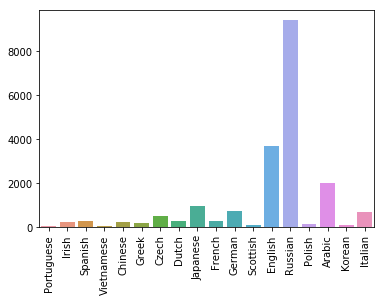

In [30]:
sns.barplot(list(label_value_counts.keys()), list(label_value_counts.values()))
plt.xticks(rotation=90)
plt.show()

Observation
1. Since the dataset is skewed,  the accuracy shouldn't be checked for overall triainset but it should be evaluated on basis per class accuracy

## 5. Model

In [31]:
image_file = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/Basic_RNN_model.JPG'
Image(image_file)

Note: Here the hidden size is to be given by the **user**

In [0]:
class RNN_net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_net, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)
    
    
  def forward(self, input_, hidden):
    combined  = torch.cat((input_,hidden),1) # concatenating the input and the previous hidden layer
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden
  
  
  
  # for the initial input (letter) we dont have the hidden layer ouputs of the previous layer
  # hence this function will be used to initiate the hidden layer for the first input
  def init_hidden(self):
    return torch.zeros(1,self.hidden_size)

In [33]:
model1 = RNN_net(55,128,10)
model1

RNN_net(
  (i2h): Linear(in_features=183, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=10, bias=True)
  (softmax): LogSoftmax()
)

- Since we are using the logarithm on softmax, we will get numbers in [-inf, 0], since log(0)=-inf and log(1)=0.
- We can get the probabilities back by using **torch.exp(output)**.

In [0]:
n_hidden = 128
n_letters = len(ascii_letters)
net = RNN_net(n_letters, n_hidden, len(languages))

In [35]:
# inference of the model

def infer_model(net,name):
  net.eval()
  hidden = net.init_hidden()
  encoded = encode_name(name)
  for i in range(encoded.size()[0]):
    output,hidden = net(encoded[i],hidden)
    
  return output

infer_model(net,'John')

tensor([[-2.9561, -2.9926, -2.9018, -2.8569, -2.8661, -2.8293, -2.8086, -2.8729,
         -2.9040, -3.0103, -2.8281, -2.9754, -2.8338, -2.8927, -2.7889, -2.9556,
         -2.8342, -2.9582]], grad_fn=<LogSoftmaxBackward>)

In [0]:
encode_name('john').size()

torch.Size([4, 1, 55])

## 6. Evaluation of the model

In [36]:
# dataloader
def dataloader(n_names, X_, Y_):
  to_ret = []
  for i in range(n_names):
    index = np.random.randint(len(X_))
    name, label = X_[index], Y_[index]
    to_ret.append((name,label,encode_name(name),encode_language(label)))
  return to_ret


for name,label,i,y in dataloader(2,X_train,Y_train):
  print(y)

tensor([6])
tensor([15])


In [39]:
def evaluation(net, n_points, k, X_, Y_):
  data = dataloader(n_points,X_,Y_)
  correct = 0
  for name,label,encoded_name, encoded_lang in data:
    output = infer_model(net,name)
    val,indices = output.topk(k)
    
    if encoded_lang in indices:
      correct += 1
      
  return correct/n_points
  
evaluation(net, 2000, 1, X_train, Y_train)

0.0335

## 7. Training the model


1. This is a sequence learning problem where we have to learn the sequence of letters in a given name and classify the name into language
2. while training the model we have to iterate over the one-hot encoded letters and compute the loss
3. then backpropagate the loss compute the gradient
4. Once the backpropagation is done for every letter in the sequence of a name then we update the weights  

### 7.1 Basic setup

In [0]:
def train_model(net, opt, criterion, n_points):
  opt.zero_grad()
  data_ = dataloader(n_points, X_train,Y_train)
  total_loss = 0
  for name, label, encoded_name, encoded_lang in data_:
    hidden = net.init_hidden()
    
    for i in range(len(encoded_name)):  # iterating over the sequence of letters in a name
      
      output,hidden = net(encoded_name[i],hidden)
      loss = criterion(output,encoded_lang)
      loss.backward(retain_graph=True)

    total_loss += loss

  opt.step()
  
  return total_loss/n_points  # return the average loss

1. Retain Graph function

**RuntimeError**: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

2. Difference between cross entropy loss and Negtive log likelihood loss (NLLLoss) 
-If our model outputs the softmax of the last layer then NLLLoss should be used otherwise we should use cross entropy loss function

In [44]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_model(net, opt, criterion, 200)

tensor(2.8904, grad_fn=<DivBackward0>)

In [0]:
## Evaluation of the model

evaluation(net, 1000, 1, X_test, Y_test)

0.454

### 7.2 Full setup for training

In [0]:
def train_setup(net,lr=0.0005, n_batches=100, batch_size=200, momentum=0.9, display_freq = 5):

  criterion = nn.NLLLoss()
  opt = optim.Adam(net.parameters(), lr=lr)
  loss = np.zeros(n_batches+1)
  for i in tqdm_notebook(range(n_batches),unit=' Batch',total=n_batches):
    loss[i+1] = (loss[i]*i + train_model(net, opt, criterion, batch_size))/(i + 1)
    if i % display_freq == 0:
      clear_output(wait=True)
      plt.figure()
      plt.plot(loss[1:i],'-*')
      plt.title('Training of Recurrent Neural Network')
      plt.xlabel('Iteration')
      plt.ylabel('Log Loss')
      plt.show() 
      
  print('Top 1 accuracy:',evaluation(net,1000,1,X_test,Y_test), '| Top 2 accuracy:',evaluation(net,1000,2,X_test,Y_test))

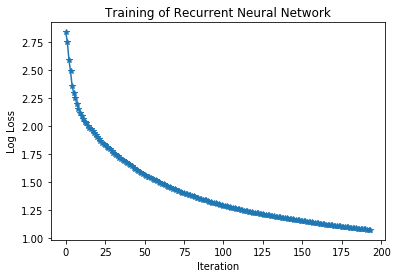


Top 1 accuracy: 0.737 | Top 2 accuracy: 0.876
CPU times: user 2min 5s, sys: 13.3 s, total: 2min 18s
Wall time: 2min 12s


In [0]:
%%time 
n_hidden = 128
lr = 0.005
net = RNN_net(n_letters, n_hidden, len(languages))
train_setup(net, lr=lr,n_batches=200, batch_size = 512)

## 8. LSTM models

Long short-term memory - used to overcome the vanishing and exploding of gradients in the sequence learning models. 

It uses selective read, write and forget algorithms to prevent the gradients from vanishing or exploding

In [0]:
class LSTM_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(LSTM_net, self).__init__()
    self.hidden_size = hidden_size
    self.lstm_cell = nn.LSTM(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    
  def forward(self, input_, hidden):
    out, hidden = self.lstm_cell(input_.view(1,1,-1), hidden)
    output = self.h2o(hidden[0])
    output = self.softmax(output)
    return output.view(1,-1), hidden
  
  def init_hidden(self):
    return (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))
    # one for the hidden state and one for the usual cell state which was also present in the simple RNN model                    

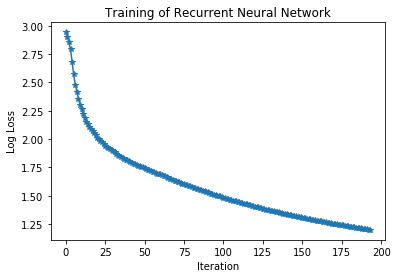


Top 1 accuracy: 0.751 | Top 2 accuracy: 0.862
CPU times: user 6min 18s, sys: 18.3 s, total: 6min 36s
Wall time: 6min 32s


In [0]:
%%time
hidden_size = 128
lstm_net = LSTM_net(n_letters, hidden_size, len(languages))
lr = 0.005
train_setup(lstm_net, lr=lr,n_batches=200, batch_size = 512)

## 8. GRU - Gated Recurrent units 

Modified version of LSTM. here it doesnot have forget gate instead it has two gates input and output

In [0]:
class GRU_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(GRU_net, self).__init__()
    self.hidden_size = hidden_size
    self.gru_cell = nn.GRU(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    
  def forward(self, input_, hidden):
    out, hidden = self.gru_cell(input_.view(1,1,-1), hidden)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output.view(1,-1), hidden
  
  def init_hidden(self):
    return torch.zeros(1,1,self.hidden_size)
    # we have only state i.e. hidden state                

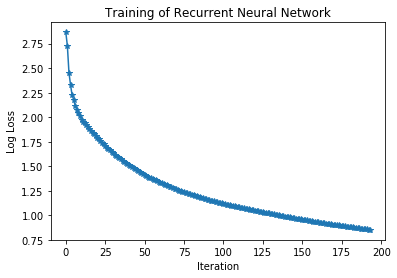


Top 1 accuracy: 0.8 | Top 2 accuracy: 0.899
CPU times: user 23min 51s, sys: 1min 4s, total: 24min 55s
Wall time: 24min 54s


In [0]:
%%time
hidden_size = 512
gru_net = GRU_net(n_letters, hidden_size, len(languages))
lr = 0.005
train_setup(gru_net, lr=lr,n_batches=200, batch_size = 512)

## 9. Exercises

1. what is cell state and hidden state
2. plot the language wise accuaracy -> plot the confusion matrix
3. Optimize the model by modifying the hyperparameters
4. Observe gradient explosion at higher learning rates
5.  Increasing the performence by using GPU
6. Use batching while training

In [0]:
lang = 'Chinese'
lang_series = pd.Series(Y)
indices = list(lang_series[lang_series==lang].index)
low,high = min(indices),max(indices)
correct = 0

for name in X[low:high]:
  prediction = languages[torch.argmax(torch.exp(infer_model(net,name))).detach().numpy()]
  if prediction == lang:
    correct +=1

correct

210

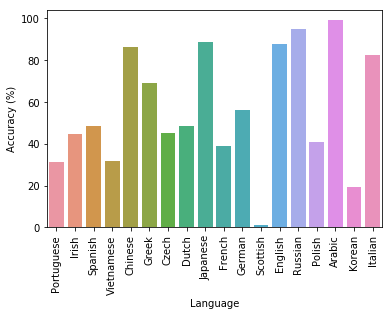

CPU times: user 60 s, sys: 941 ms, total: 1min
Wall time: 1min


In [0]:
%%time
## accuracy per language 
def per_class_accuracy(model):
  output = {}
  lang_series = pd.Series(Y)
  
  for lang in languages:
    correct = 0    
    indices = list(lang_series[lang_series==lang].index)
    low,high = min(indices),max(indices)
   
    for name in X[low:high]:
      prediction = languages[torch.argmax(torch.exp(infer_model(model,name))).detach().numpy()]
      if prediction == lang:
        correct +=1
        
    output[lang] = correct/len(indices)*100
    
  return output


accuracies = per_class_accuracy(gru_net)
sns.barplot(list(accuracies.keys()),list(accuracies.values()))
plt.xticks(rotation=90)
plt.xlabel('Language')
plt.ylabel('Accuracy (%)')
plt.show() 

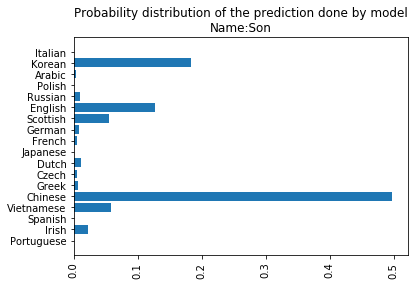

In [0]:
name = 'Son'
plt.barh(languages,torch.exp(infer_model(net,name)).detach().numpy().flatten())
plt.title('Probability distribution of the prediction done by model\nName:'+name)
plt.xticks(rotation=90)
plt.show()